In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special



def weight(n):
    return 2 * n**2

def boltzmann(n1, n2, eV, T):
    k = 8.6173303e-5  # Boltzmann constant in eV/K
    g_n = weight(n2) / weight(n1) * np.exp(-eV / (k * T))
    return g_n

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.5e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x

# rr = np.arange(12, 19, 1)
# ee = np.arange(0,725,25)
# em = np.arange(25,725,25)
# em = np.append(1,em)
# random_v = np.arange(250,7250,250)
# random_v = np.append(118,random_v)

rr = np.arange(13, 17, 1)
ee = np.arange(1,7,1)
em = np.arange(100,700,100)
em = np.append([1],em)
atom = [13,20,32,50,79]


# atom = [13,20,32,50,79]

C_IV_K_A = 1548.187  # cm
C_IV_H_A = 1550.772


rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * atom / 10
total_N_c = total_N_c.flatten()

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm
cc = c.to(u.cm / u.s).value  # cm/s
cc_k = c.to(u.km / u.s).value #km / s
v_th_CIV = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952


NN = int(1e4)
xx = np.linspace(-3, 3, NN)
yy = np.linspace(-6,6, NN)



def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def change_x_to_lam(x,v_th ,lines):
    del_lam_D = v_th / lines
    return lines / (x * v_th / cc + 1)



def N_esc_scat(v_th):
    C_iv_N = np.linspace(1e12, 1e17, NN)
    # total_tau = np.zeros((len(C_iv_N), 1e6))

    # 벡터화된 tau 및 Voigt 프로파일 계산
    Voigt_profile = Voigt(xx,v_th,K_gamma, C_IV_K)
    tau_profile = tau(sig_c, C_iv_N[:, None]) * Voigt_profile


    # x_0 계산
    x_0 = np.zeros(len(C_iv_N))
    for ii, jj in enumerate(C_iv_N):
        x_p = np.where(np.diff(np.sign(1 - tau_profile[ii, :])))[0]
        x_0[ii] = xx[x_p].max() if x_p.size > 0 else 0

    del_lam_D = v_th / C_IV_K
    nu_0_K= cc/C_IV_K
    nu_esc = x_0*del_lam_D + nu_0_K
    V_del_peak = 2 * abs((nu_esc - nu_0_K)/nu_0_K) * cc/1e5 #km/s
    v_esc = x_0*v_th
    N_esc= 1/special.erfc(v_esc/v_th)

    return C_iv_N, N_esc , V_del_peak



def gauss_func(F_c,x,x_0,sig):
    xx = np.linspace(x.min(),x.max(),1000)
    ss = (xx-x_0)/sig
    ex = np.zeros(len(xx))
    ex = F_c*np.exp(-ss**2/2)
    return  xx,ex

# plt.plot(del_V_space_g,yy_g)

3.39090e+13


In [2]:
nu = 0
v_ran = 118
directory_1 = '/home/jin/data_jin/'
for a , index in enumerate(rr):
    for b, expand in enumerate(ee):
        if expand == 10 :
            expand_v = 1
            num_ev = 3 
        else: 
            num_ev = 2
            expand_v = expand
        for c, emit in enumerate(em):
            if emit == 1 :
                 emit_v = 100
                 num_emit = 0

            elif emit == 50 or emit == 10:
                emit_v = emit * 10
                num_emit = 1
            else : 
                emit_v = emit
                num_emit = 2

            for d, atom_n in enumerate(atom):
                path_sp = f'{directory_1}N_atom{atom_n}0E+{index}_Vexp{expand_v}00E+0{num_ev}_Vemit{emit_v}E+0{num_emit}_tauD000E+00_Vran118E+01spec_com.dat'         
                try:
                    data_sp = pd.read_csv(path_sp, sep='\s+', header=None)
                except FileNotFoundError:
                    print(f"파일을 찾을 수 없습니다: {path_sp}")
                    nu += 1
                    continue 

                globals()[f'data_sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = pd.read_csv(path_sp, sep='\s+', header=None)
                globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'data_sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][0]
                globals()[f'sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'data_sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][2]

                # K and H line seperate
                lam_c = (C_IV_K_A+C_IV_H_A)/2
                #K line
                globals()[f'lambda_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] [globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] <= lam_c]
                globals()[f'flux_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] [globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] <= lam_c]
                #H line
                globals()[f'lambda_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] [globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] >= lam_c]
                globals()[f'flux_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] [globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] >= lam_c]

                #K line double peak separate
                # K line center -  approximate 0.002% remove
                # Because of the direcetly escape photons
                X_K_P = globals()[f'lambda_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][globals()[f'lambda_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] >= 1548.218].to_numpy()
                X_K_N = globals()[f'lambda_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][globals()[f'lambda_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] <= 1548.156].to_numpy()
                filtered_series_K_pos_1 = globals()[f'flux_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][globals()[f'lambda_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] >= 1548.218].to_numpy()
                filtered_series_K_neg_1 = globals()[f'flux_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][globals()[f'lambda_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] <= 1548.156].to_numpy()

                tt_K = (globals()[f'lambda_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] <= 1548.156) | (globals()[f'lambda_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] >= 1548.218)

                # 조건을 만족하지 않는 요소를 추출
                globals()[f'x_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = np.compress(tt_K,globals()[f'lambda_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'])
                globals()[f'y_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}']= np.compress(tt_K, globals()[f'flux_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'])
                

                #H line double peak separate
                # H line center -  approximate 0.002% remove
                # Because of the direcetly escape photons

                X_H_P = globals()[f'lambda_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][globals()[f'lambda_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] >= 1550.783].to_numpy()
                X_H_N = globals()[f'lambda_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][globals()[f'lambda_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] <= 1550.721].to_numpy()
                filtered_series_H_pos_1 = globals()[f'flux_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][globals()[f'lambda_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] >= 1550.783].to_numpy()
                filtered_series_H_neg_1 = globals()[f'flux_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][globals()[f'lambda_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] <= 1550.721].to_numpy()

                tt_H = (globals()[f'lambda_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] <= 1550.721) | (globals()[f'lambda_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] > 1550.783)

                # 조건을 만족하지 않는 요소를 추출
                globals()[f'x_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = np.compress(tt_H,globals()[f'lambda_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'])
                globals()[f'y_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}']= np.compress(tt_H, globals()[f'flux_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'])




                globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = ((globals()[f'x_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] - C_IV_K_A) /  C_IV_K_A)*cc_k
                globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}']=  globals()[f'y_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}']



                globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = ((globals()[f'x_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] - C_IV_K_A) /  C_IV_K_A)*cc_k
                globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}']=  globals()[f'y_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}']

                # globals()[f'delta_lam_K_{atom_n}_{index}_{expand}_{emit}'] = delta_lam_K
                # globals()[f'delta_lam_H_{atom_n}_{index}_{expand}_{emit}'] = delta_lam_H  


                # globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'] = int_Vel_K 
                # globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'] = int_flux_K

                # globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'] = int_Vel_H  
                # globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'] = int_flux_H             
print(nu)

파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom130E+13_Vexp100E+02_Vemit400E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom200E+13_Vexp100E+02_Vemit400E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom320E+13_Vexp100E+02_Vemit400E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom500E+13_Vexp100E+02_Vemit400E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom790E+13_Vexp100E+02_Vemit400E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom130E+13_Vexp100E+02_Vemit500E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom200E+13_Vexp100E+02_Vemit500E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom320E+13_Vexp100E+02_Vemit500E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom500E+13_Vexp100E+02_Vemit500E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /hom

In [3]:

def analy_function(sigma):
    NN = 10000  
    xx = np.linspace(1530,1570,NN)
    sp_dlam_1 = xx
    tv_k = ((xx-C_IV_K_A ) / C_IV_K_A ) * cc_k
    tv_h = ((xx-C_IV_H_A) / C_IV_H_A ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    sp_1 = fx
    del_V_space = (sp_dlam_1 / C_IV_K  - 1) * cc_k

    lam_c= ((C_IV_H_A + C_IV_K_A)/2)

    
    indices_K_V = np.where(xx <= lam_c)[0]
    indices_H_V = np.where(xx >=lam_c)[0]

    sp_V_K = del_V_space[indices_K_V]
    sp_V_H = del_V_space[indices_H_V]

    sp_K_f = sp_1[indices_K_V]
    sp_H_f = sp_1[indices_H_V] 

    sp_lam_K = sp_dlam_1[indices_K_V]
    sp_lam_H = sp_dlam_1[indices_H_V]

    dk = sp_lam_K[1]-sp_lam_K[0]  
    int_k = np.sum(dk*sp_K_f,axis=0)
    dh = sp_lam_H[1]-sp_lam_H[0]  
    int_h = np.sum(dh*sp_H_f,axis=0)
    RC = int_k/ int_h
    # print(len(fx/f0))
    return RC , fx/f0

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0')])

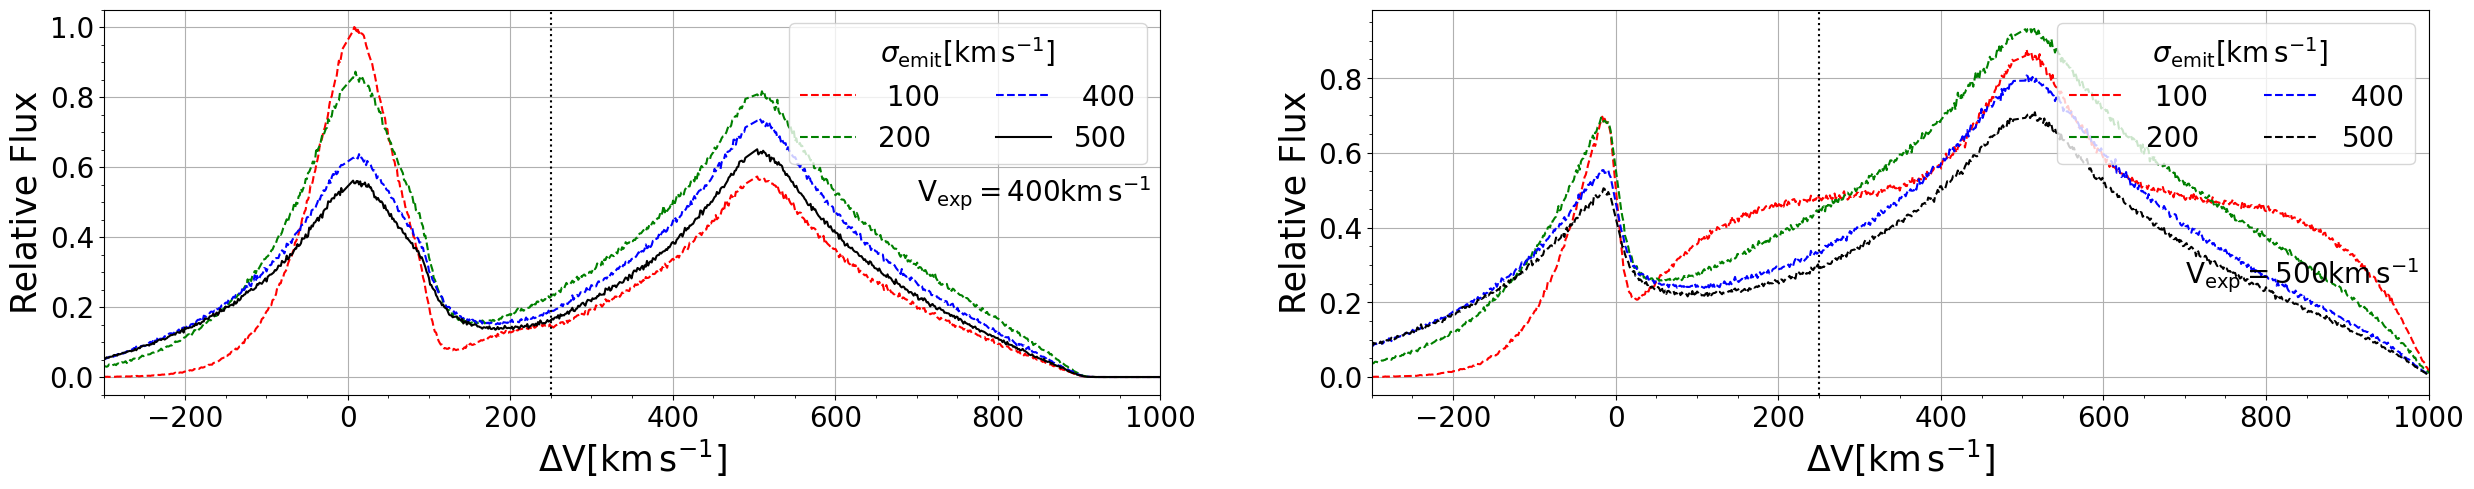

In [4]:
fig = plt.figure(1,figsize=(30,5))

plt.subplot(121)
atom_n,index, expand = 32,15,4
v_ran= 118
emit_n = 100
normal =  max(globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'])
#max(globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'])
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/normal,'r--',label=f' {emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}']/normal,'r--')

emit_n = 200
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal ,'g--',label=f'{emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'g--')

emit_n = 400
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'b--',label=f' {emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'b--')

emit_n = 500
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'k-',alpha=1.0,label=f'{emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'k-',alpha=1.0)

# emit_n = 100
# # normal =  max(globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'])
# #max(globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'])
# plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/normal,'r--',alpha=0.5,label=f' {emit_n}')
# plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}']/normal,'r--',alpha=0.5)

vv = ((C_IV_H_A/C_IV_K_A-1)*cc_k /2)
plt.axvline(vv ,ymin=0,ymax=10,color='k',linestyle=':')
plt.xlim(-300, 1000)
plt.minorticks_on()
# plt.xlim(-1500,1500)
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=2,title=r'$\sigma_{{\rm emit}} [\rm km \, s^{{-1}} ]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V [\rm km \, s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.text(700,0.5,f'$\\rm V_{{\\rm exp}} = {expand}00 \\rm km \\, s^{{-1}}$',size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.subplot(122)
atom_n,index, expand = 32,15,5

emit_n = 100
# normal = max(globals()[f'y_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'])
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/normal,'r--',label=f' {emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/normal,'r--')

emit_n = 200
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal ,'g--',label=f'{emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'g--')

emit_n = 400
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'b--',label=f' {emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'b--')

emit_n = 500
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'k--',label=f'{emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'k--')



vv = ((C_IV_H_A/C_IV_K_A-1)*cc_k /2)
plt.axvline(vv ,ymin=0,ymax=10,color='k',linestyle=':')
plt.xlim(-300, 1000)
plt.minorticks_on()
# plt.xlim(-1500,1500)
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=2,title=r' $\sigma_{\rm emit} [\rm km \, s^{-1} ]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V [\rm km \, s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.text(700,0.25,f'$\\rm V_{{\\rm exp}} = {expand}00 \\rm km \\, s^{{-1}}$',size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.savefig(r'/home/jin/바탕화면/N_CIV_15_emit_vexp.pdf',bbox_inches='tight')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0')])

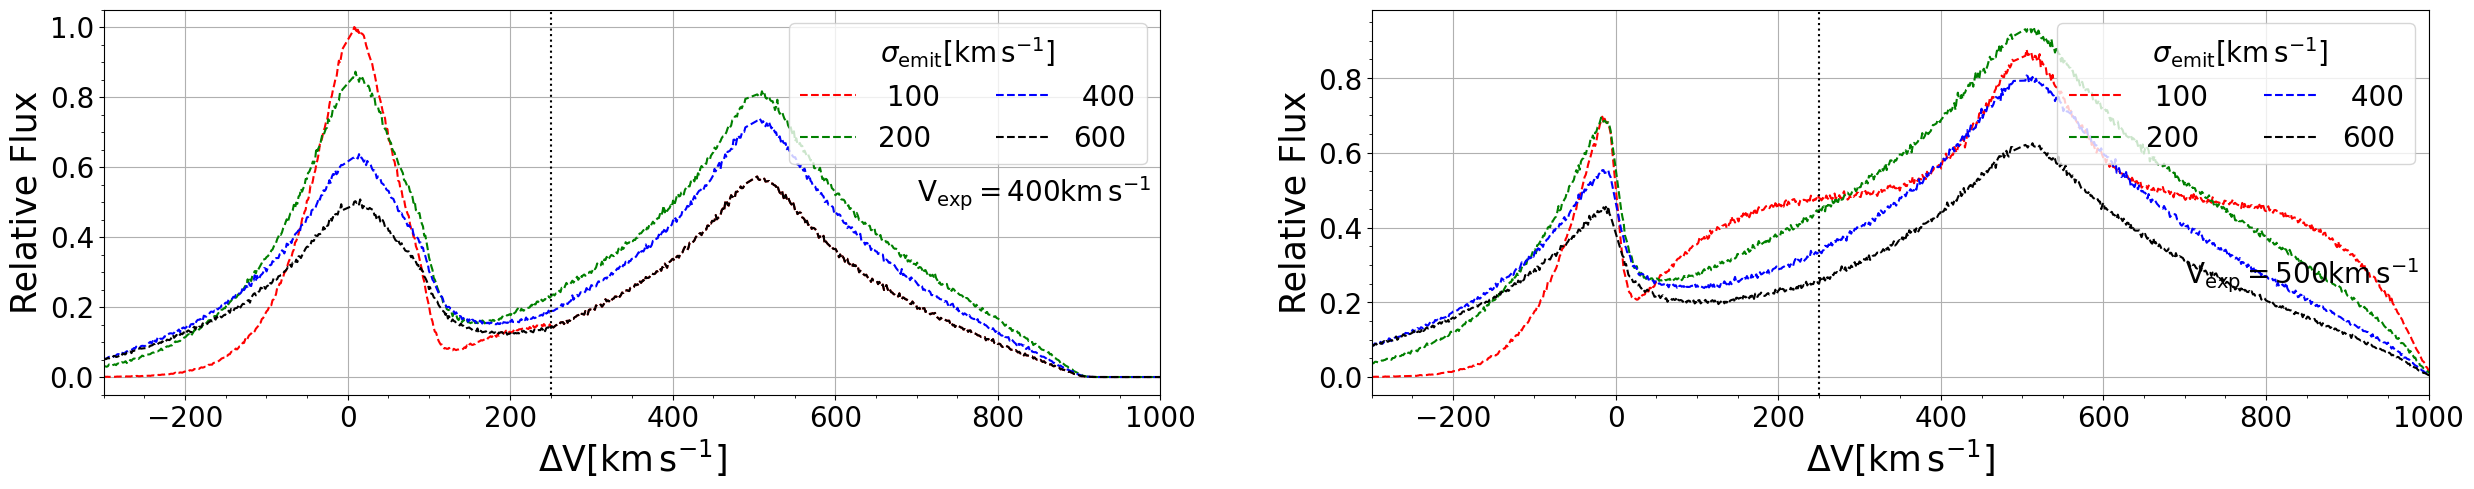

In [5]:
fig = plt.figure(1,figsize=(30,5))

plt.subplot(121)
atom_n,index, expand = 32,15,4
v_ran= 118
emit_n = 100
normal =  max(globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'])
#max(globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'])
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/normal,'r--',label=f' {emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}']/normal,'r--')

emit_n = 200
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal ,'g--',label=f'{emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'g--')

emit_n = 400
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'b--',label=f' {emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'b--')

emit_n = 600
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'k--',label=f'{emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'k--')


vv = ((C_IV_H_A/C_IV_K_A-1)*cc_k /2)
plt.axvline(vv ,ymin=0,ymax=10,color='k',linestyle=':')
plt.xlim(-300, 1000)
plt.minorticks_on()
# plt.xlim(-1500,1500)
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=2,title=r'$\sigma_{{\rm emit}} [\rm km \, s^{{-1}} ]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V [\rm km \, s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.text(700,0.5,f'$\\rm V_{{\\rm exp}} = {expand}00 \\rm km \\, s^{{-1}}$',size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.subplot(122)
atom_n,index, expand = 32,15,5
emit_n = 100
# normal = max(globals()[f'y_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'])
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/normal,'r--',label=f' {emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/normal,'r--')

emit_n = 200
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal ,'g--',label=f'{emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'g--')

emit_n = 400
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'b--',label=f' {emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'b--')

emit_n = 600
plt.plot(globals()[f'vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'k--',label=f'{emit_n}')
plt.plot(globals()[f'vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] ,globals()[f'vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}']/ normal,'k--')


vv = ((C_IV_H_A/C_IV_K_A-1)*cc_k /2)
plt.axvline(vv ,ymin=0,ymax=10,color='k',linestyle=':')
plt.xlim(-300, 1000)
plt.minorticks_on()
# plt.xlim(-1500,1500)
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=2,title=r' $\sigma_{\rm emit} [\rm km \, s^{-1} ]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V [\rm km \, s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.text(700,0.25,f'$\\rm V_{{\\rm exp}} = {expand}00 \\rm km \\, s^{{-1}}$',size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.savefig(r'/home/jin/바탕화면/N_CIV_15_emit_vexp.pdf',bbox_inches='tight')

In [6]:
nu = 0
for a , index in enumerate(rr):
    for b, expand in enumerate(ee):
        if expand == 10 :
            expand_v = 1
            num_ev = 3 
        else: 
            num_ev = 2
            expand_v = expand
        for c, emit in enumerate(em):
            if emit == 1 :
                 emit_v = 100
                 num_emit = 0

            elif emit == 50 or emit == 10:
                emit_v = emit * 10
                num_emit = 1
            else : 
                emit_v = emit
                num_emit = 2

            for d, atom_n in enumerate(atom):
                path_sp_1 = f'{directory_1}N_atom{atom_n}0E+{index}_Vexp{expand_v}00E+0{num_ev}_Vemit{emit_v}E+0{num_emit}_tauD000E+00_Vran118E+01spec_com.dat'         
                try:
                    data_sp_1 = pd.read_csv(path_sp_1, sep='\s+', header=None)
                except FileNotFoundError:
                    print(f"파일을 찾을 수 없습니다: {path_sp_1}")
                    nu += 1
                    continue 

                
                sp_dlam_1 = data_sp_1[0].to_numpy()
                globals()[f'Lambda_{atom_n}_{index}_{expand}_{emit}'] =   sp_dlam_1
                sp_1 = data_sp_1[2].to_numpy()

                indices_K_1 = np.where(sp_dlam_1 <= 1550)[0]
                indices_H_1 = np.where(sp_dlam_1 > 1550)[0]

                sp_dlam_K = sp_dlam_1[indices_K_1]
                sp_dlam_H = sp_dlam_1[indices_H_1]

                dlam_k = sp_dlam_K[1]-sp_dlam_K[0]
                dlam_h = sp_dlam_H[1]-sp_dlam_H[0]
                dlam_sp =sp_dlam_1[1] -sp_dlam_1[0]
                # print(dlam_k ,dlam_h,dlam_sp)

                sp_K = sp_1[indices_K_1]
                sp_H = sp_1[indices_H_1]

                if len(sp_K) == 0 or len(sp_H) == 0:
                    print(f"데이터 부족: {path_sp_1}")
                    continue

                del_V_space = (sp_dlam_1 / C_IV_K_A  - 1) * cc / 1e5  # km/s

                lam_c = (C_IV_H_A+C_IV_K_A) / 2
                # print(sep_point)
                indices_K_sp = np.where(sp_dlam_1 <= lam_c )[0]
                indices_H_sp = np.where(sp_dlam_1> lam_c)[0]

                int_Vel_K = del_V_space[indices_K_sp]
                int_Vel_H = del_V_space[indices_H_sp]

                int_flux_K = sp_1[indices_K_sp]
                int_flux_H = sp_1[indices_H_sp]

                delta_lam_K = sp_dlam_1[indices_K_sp]
                delta_lam_H = sp_dlam_1[indices_H_sp]
                globals()[f'delta_lam_K_{atom_n}_{index}_{expand}_{emit}'] = delta_lam_K
                globals()[f'delta_lam_H_{atom_n}_{index}_{expand}_{emit}'] = delta_lam_H  


                globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'] = int_Vel_K 
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'] = int_flux_K

                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'] = int_Vel_H  
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'] = int_flux_H             
print(nu)

파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom130E+13_Vexp100E+02_Vemit400E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom200E+13_Vexp100E+02_Vemit400E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom320E+13_Vexp100E+02_Vemit400E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom500E+13_Vexp100E+02_Vemit400E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom790E+13_Vexp100E+02_Vemit400E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom130E+13_Vexp100E+02_Vemit500E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom200E+13_Vexp100E+02_Vemit500E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom320E+13_Vexp100E+02_Vemit500E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /home/jin/data_jin/N_atom500E+13_Vexp100E+02_Vemit500E+02_tauD000E+00_Vran118E+01spec_com.dat
파일을 찾을 수 없습니다: /hom

In [7]:

def analy_function(sigma):
    NN = 10000  
    xx = np.linspace(1530,1570,NN)
    sp_dlam_1 = xx
    tv_k = ((xx-C_IV_K_A ) / C_IV_K_A ) * cc_k
    tv_h = ((xx-C_IV_H_A) / C_IV_H_A ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    sp_1 = fx
    del_V_space = (sp_dlam_1 / C_IV_K  - 1) * cc_k

    lam_c= ((C_IV_H_A + C_IV_K_A)/2)

    
    indices_K_V = np.where(xx <= lam_c)[0]
    indices_H_V = np.where(xx >=lam_c)[0]

    sp_V_K = del_V_space[indices_K_V]
    sp_V_H = del_V_space[indices_H_V]

    sp_K_f = sp_1[indices_K_V]
    sp_H_f = sp_1[indices_H_V] 

    sp_lam_K = sp_dlam_1[indices_K_V]
    sp_lam_H = sp_dlam_1[indices_H_V]

    dk = sp_lam_K[1]-sp_lam_K[0]  
    int_k = np.sum(dk*sp_K_f,axis=0)
    dh = sp_lam_H[1]-sp_lam_H[0]  
    int_h = np.sum(dh*sp_H_f,axis=0)
    RC = int_k/ int_h
    # print(len(fx/f0))
    return RC , fx/f0

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

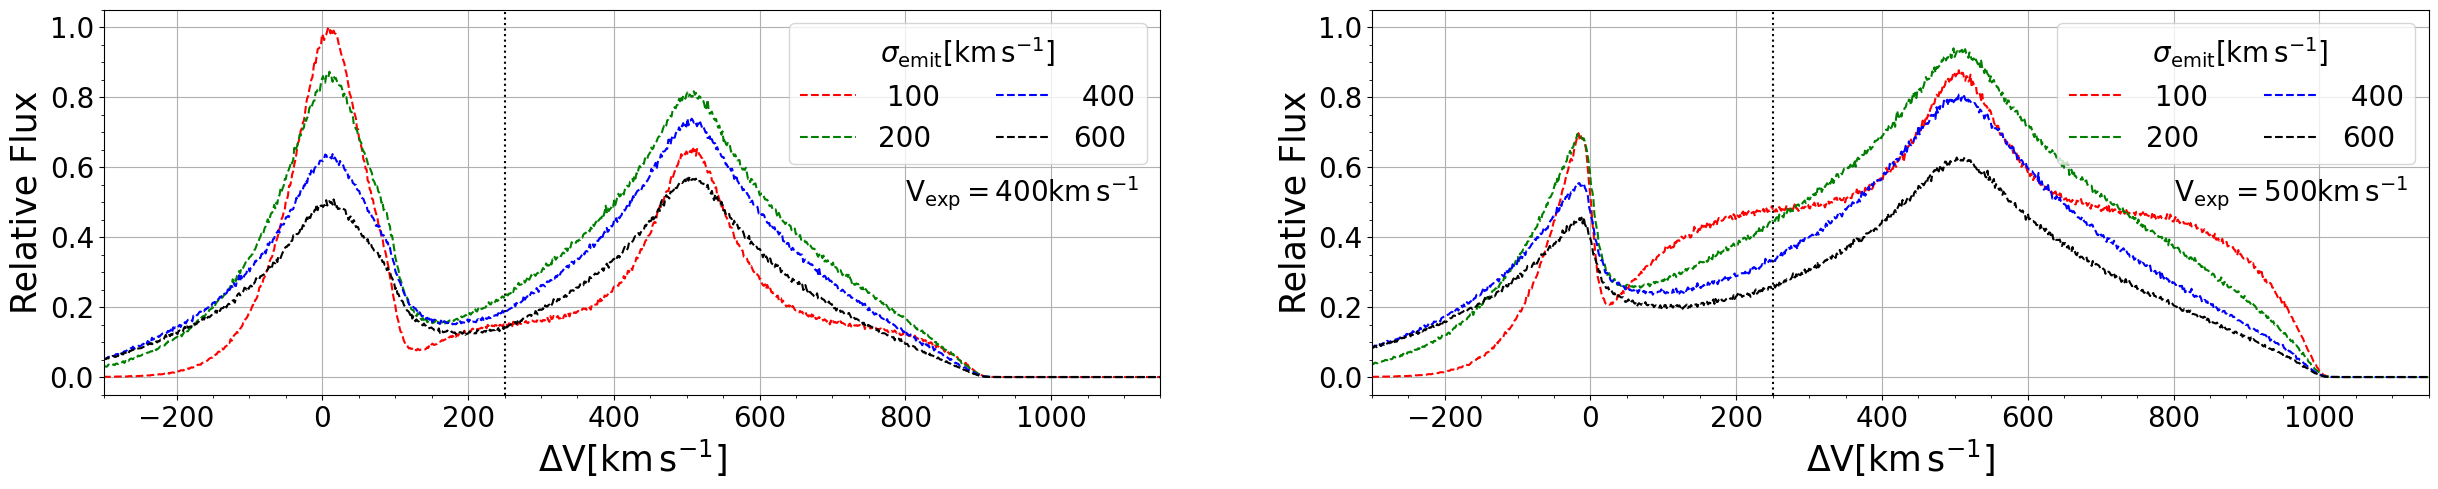

In [8]:
fig = plt.figure(1,figsize=(30,5))

plt.subplot(121)
atom_n,index, expand = 32,15,4
emit_n = 100
normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/normal,'r--',label=f' {emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/normal,'r--')

emit_n = 200
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal ,'g--',label=f'{emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'g--')

emit_n = 400
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'b--',label=f' {emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'b--')

emit_n = 600
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'k--',label=f'{emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'k--')


vv = ((C_IV_H_A/C_IV_K_A-1)*cc_k /2)
plt.axvline(vv ,ymin=0,ymax=10,color='k',linestyle=':')
plt.xlim(-300, 1150)
plt.minorticks_on()
# plt.xlim(-1500,1500)
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=2,title=r'$\sigma_{{\rm emit}} [\rm km \, s^{{-1}} ]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V [\rm km \, s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.text(800,0.5,f'$\\rm V_{{\\rm exp}} = {expand}00 \\rm km \\, s^{{-1}}$',size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.subplot(122)
atom_n,index, expand = 32,15,5
emit_n = 100
# normal = max(globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/normal,'r--',label=f' {emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/normal,'r--')

emit_n = 200
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal ,'g--',label=f'{emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'g--')

emit_n = 400
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'b--',label=f' {emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'b--')

emit_n = 600
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'k--',label=f'{emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'k--')


vv = ((C_IV_H_A/C_IV_K_A-1)*cc_k /2)
plt.axvline(vv ,ymin=0,ymax=10,color='k',linestyle=':')
plt.xlim(-300, 1150)
plt.ylim(-0.05,1.05)
plt.minorticks_on()
# plt.xlim(-1500,1500)
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=2,title=r' $\sigma_{\rm emit} [\rm km \, s^{-1} ]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V [\rm km \, s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.text(800,0.5,f'$\\rm V_{{\\rm exp}} = {expand}00 \\rm km \\, s^{{-1}}$',size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.savefig(r'/home/jin/바탕화면/N_CIV_15_emit_vexp.pdf',bbox_inches='tight')

In [9]:
def ratio(x_1,y_1,x_2,y_2):
    delx_1 = x_1[1]- x_1[0]
    total_1 = np.sum(y_1*delx_1,axis=0)
    delx_2 = x_2[1]- x_2[0]
    total_2 = np.sum(y_2*delx_2,axis=0)
    ratio = total_1 / total_2
    return ratio

def function(sigma,lam,lam_k,lam_h):
    tv_k = ((lam-lam_k) / lam_k ) * cc_k
    tv_h = ((lam-lam_h) / lam_h ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    return fx , f0

NN = 10000
x = np.linspace(1530,1570,NN)
sigma_tt = np.arange(10,610,10)
C_IV_K = 1548.187 # cm
C_IV_H = 1550.772  # cm
R_c_tt = np.zeros(len(sigma_tt)) 
lam_c = (C_IV_H +C_IV_K) / 2
for ii, sig in (enumerate(sigma_tt)):
    ff,f0 = function(sig,x,C_IV_K,C_IV_H)
    xx_k = x[x<=lam_c]
    xx_h = x[x>lam_c]   
    ff_k = ff[x<=lam_c]
    ff_h = ff[x>lam_c] 
    dlam = x[1]-x[0]
    flux_k = np.sum(ff_k*dlam,axis=0)
    flux_h = np.sum(ff_h*dlam,axis=0)
    R_c_tt[ii] = flux_k/ flux_h


NN = 10000
x = np.linspace(1530,1570,NN)

Variable not found: 'I_K_dv_32_13_4_400'
Variable not found: 'I_K_dv_32_13_4_500'
Variable not found: 'I_K_dv_32_13_4_600'
Variable not found: 'I_K_dv_32_14_4_400'
Variable not found: 'I_K_dv_32_14_4_500'
Variable not found: 'I_K_dv_32_14_4_600'


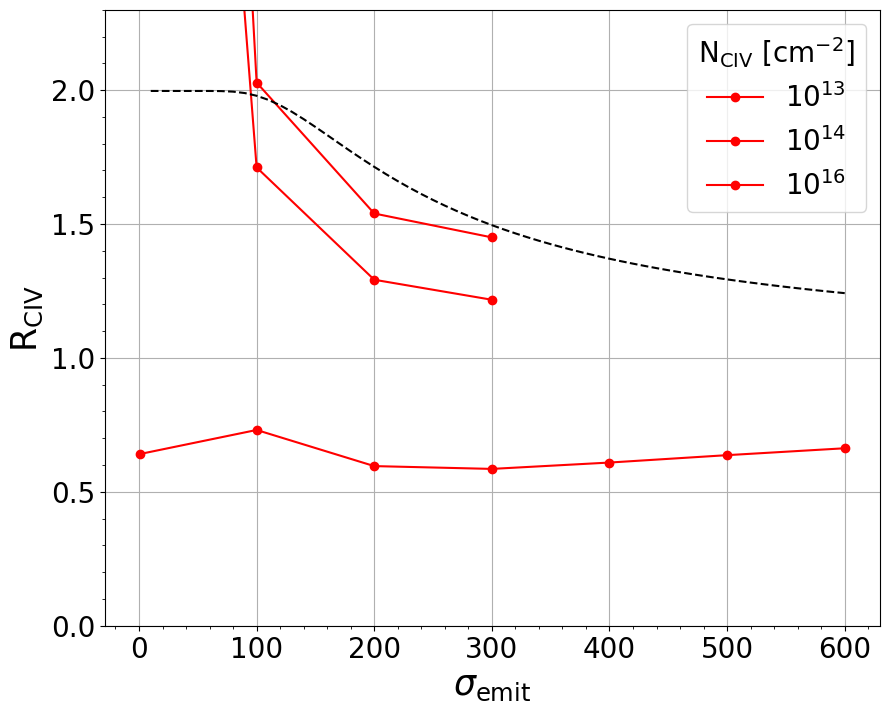

In [10]:
fig = plt.figure(1,figsize=(10,8))
atom_n, expand = 32, 4

# 첫 번째 조합: index = 13
index = 13
first_label = True
Ratio = np.zeros(len(em))
for ii, emit_n in enumerate(em):
    try:
        R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
        Ratio[ii] = R_C
    except KeyError as e:
        print(f"Variable not found: {e}")
        Ratio[ii] = np.nan  # 변수가 없을 경우 NaN 값 대입 (또는 다른 값으로 대체 가능)
        
plt.plot(em, Ratio, 'ro-', label=f'$10^{{{index}}}$')

# 두 번째 조합: index = 15
index = 14
Ratio = np.zeros(len(em))
for ii, emit_n in enumerate(em):
    try:
        R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
        Ratio[ii] = R_C
    except KeyError as e:
        print(f"Variable not found: {e}")
        Ratio[ii] = np.nan  # 변수가 없을 경우 NaN 값 대입 (또는 다른 값으로 대체 가능)
        
plt.plot(em, Ratio, 'ro-', label=f'$10^{{{index}}}$')

# 세 번째 조합: index = 17
index = 16
Ratio = np.zeros(len(em))
for ii, emit_n in enumerate(em):
    try:
        R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
        Ratio[ii] = R_C
    except KeyError as e:
        print(f"Variable not found: {e}")
        Ratio[ii] = np.nan  # 변수가 없을 경우 NaN 값 대입 (또는 다른 값으로 대체 가능)
        
plt.plot(em, Ratio, 'ro-', label=f'$10^{{{index}}}$')

plt.legend(fontsize=20,title=f'$\\rm N_{{\\rm CIV}} ~[\\rm cm^{{-2}}]$',title_fontsize=20)
plt.plot(sigma_tt,R_c_tt,'k--')
plt.ylim(0,2+0.3)
plt.xlabel(r'$\sigma_{\rm emit}$',fontsize=25)
plt.ylabel(r'$\rm R_{\rm CIV}$',fontsize=25)
plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=20)
plt.xticks(fontsize=20)
plt.grid(True)
plt.minorticks_on()
# plt.savefig(r'/home/jin/바탕화면/Vexp_400_N_CIV_emit.pdf',bbox_inches='tight')

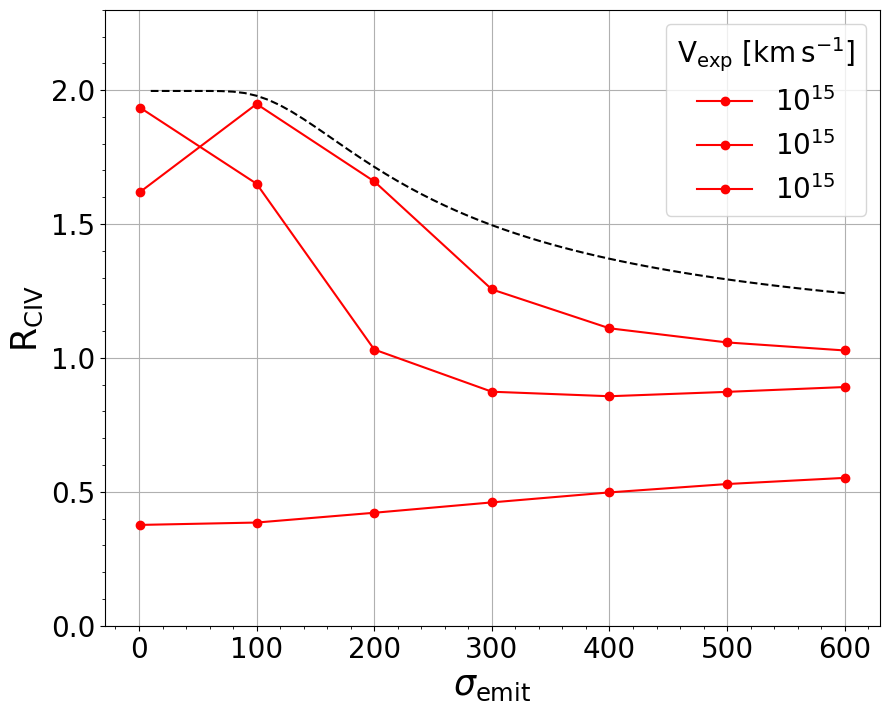

In [11]:
fig = plt.figure(1,figsize=(10,8))
atom_n, index= 32, 15

# 첫 번째 조합: index = 13
expand = 1
Ratio = np.zeros(len(em))
for ii, emit_n in enumerate(em):
    try:
        R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
        Ratio[ii] = R_C
    except KeyError as e:
        print(f"Variable not found: {e}")
        Ratio[ii] = np.nan  # 변수가 없을 경우 NaN 값 대입 (또는 다른 값으로 대체 가능)
        
plt.plot(em, Ratio, 'ro-', label=f'$10^{{{index}}}$')
# 두 번째 조합: index = 15
expand = 3
Ratio = np.zeros(len(em))
for ii, emit_n in enumerate(em):
    try:
        R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
        Ratio[ii] = R_C
    except KeyError as e:
        print(f"Variable not found: {e}")
        Ratio[ii] = np.nan  # 변수가 없을 경우 NaN 값 대입 (또는 다른 값으로 대체 가능)
        
plt.plot(em, Ratio, 'ro-', label=f'$10^{{{index}}}$')

# 세 번째 조합: index = 17
expand = 5
Ratio = np.zeros(len(em))
for ii, emit_n in enumerate(em):
    try:
        R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                    globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
        Ratio[ii] = R_C
    except KeyError as e:
        print(f"Variable not found: {e}")
        Ratio[ii] = np.nan  # 변수가 없을 경우 NaN 값 대입 (또는 다른 값으로 대체 가능)
        
plt.plot(em, Ratio, 'ro-', label=f'$10^{{{index}}}$')
# $\\rm V_{{\\rm exp}} = {expand}00 km \, s^{{{-1}}}$
plt.legend(fontsize=20,title=f'$\\rm V_{{\\rm exp}}  ~ [km \, s^{{{-1}}}]$',title_fontsize=20)
plt.plot(sigma_tt,R_c_tt,'k--')
plt.ylim(0,2+0.3)
plt.xlabel(r'$\sigma_{\rm emit}$',fontsize=25)
plt.ylabel(r'$\rm R_{\rm CIV}$',fontsize=25)
plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=20)
plt.xticks(fontsize=20)
plt.minorticks_on()
plt.grid(True)
# plt.savefig(r'/home/jin/바탕화면/N_CIV_15_Vexp_emit.pdf',bbox_inches='tight')

Variable not found: 'I_K_dv_50_12_1_100'
Variable not found: 'I_K_dv_50_12_2_100'
Variable not found: 'I_K_dv_50_12_3_100'
Variable not found: 'I_K_dv_50_12_4_100'
Variable not found: 'I_K_dv_50_12_5_100'
Variable not found: 'I_K_dv_50_12_6_100'
Variable not found: 'I_K_dv_50_12_1_200'
Variable not found: 'I_K_dv_50_12_2_200'
Variable not found: 'I_K_dv_50_12_3_200'
Variable not found: 'I_K_dv_50_12_4_200'
Variable not found: 'I_K_dv_50_12_5_200'
Variable not found: 'I_K_dv_50_12_6_200'
Variable not found: 'I_K_dv_50_12_1_500'
Variable not found: 'I_K_dv_50_12_2_500'
Variable not found: 'I_K_dv_50_12_3_500'
Variable not found: 'I_K_dv_50_12_4_500'
Variable not found: 'I_K_dv_50_12_5_500'
Variable not found: 'I_K_dv_50_12_6_500'


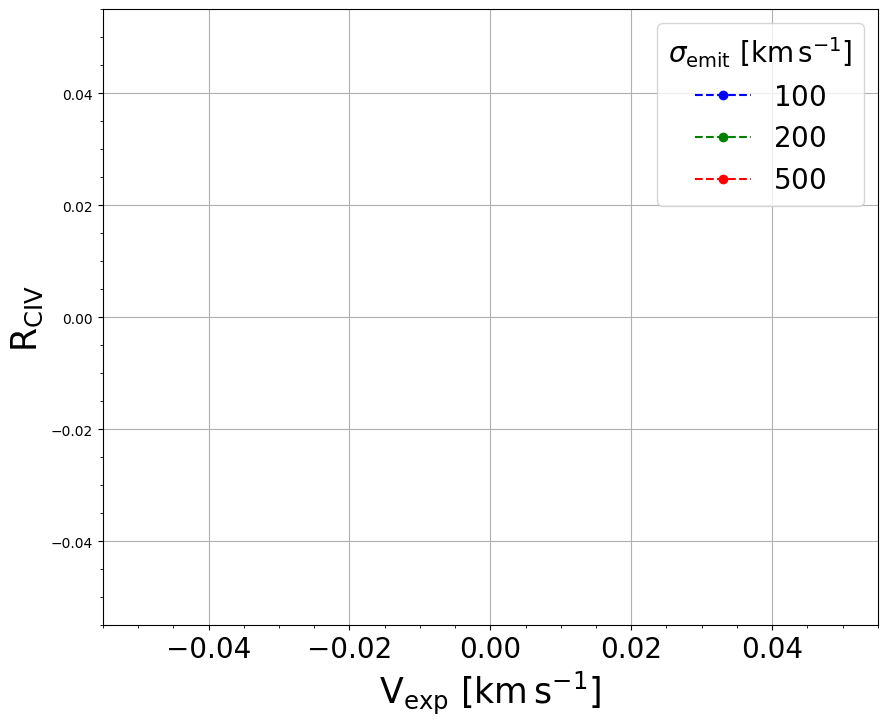

In [17]:
fig = plt.figure(1,figsize=(10,8))
atom_n, index= 50, 12

# emit = 1
# first_label = True

# Ratio = np.zeros(len(ee))
# velocity = np.zeros(len(ee))
# for ii, expand in enumerate(ee):
#     try:
#         R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'],
#                     globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'],
#                     globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'],
#                     globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'])
#         Ratio[ii] = R_C
#         velocity[ii] = expand * 100 
#     except KeyError as e:
#         print(f"Variable not found: {e}")
#         Ratio[ii] = np.nan       # 변수가 없을 경우 NaN 값 대입 (또는 다른 값으로 대체 가능)
#         velocity[ii] = expand * 100  # velocity 값은 계속 계산할 수 있으므로 유지
        
# plt.plot(velocity, Ratio, 'ko--', label=f'${emit} $')


emit = 100
first_label = True

Ratio = np.zeros(len(ee))
velocity = np.zeros(len(ee))
for ii, expand in enumerate(ee):
    try:
        R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'],
                    globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'],
                    globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'],
                    globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'])
        Ratio[ii] = R_C
        velocity[ii] = expand * 100 
    except KeyError as e:
        print(f"Variable not found: {e}")
        Ratio[ii] = np.nan       # 변수가 없을 경우 NaN 값 대입 (또는 다른 값으로 대체 가능)
        velocity[ii] = expand * 100  # velocity 값은 계속 계산할 수 있으므로 유지
        
plt.plot(velocity, Ratio, 'bo--', label=f'${emit} $')

emit = 200
first_label = True

Ratio = np.zeros(len(ee))
velocity = np.zeros(len(ee))
for ii, expand in enumerate(ee):
    try:
        R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'],
                    globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'],
                    globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'],
                    globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'])
        Ratio[ii] = R_C
        velocity[ii] = expand * 100 
    except KeyError as e:
        print(f"Variable not found: {e}")
        Ratio[ii] = np.nan       # 변수가 없을 경우 NaN 값 대입 (또는 다른 값으로 대체 가능)
        velocity[ii] = expand * 100  # velocity 값은 계속 계산할 수 있으므로 유지
        
plt.plot(velocity, Ratio, 'go--', label=f'${emit} $')


emit = 500
first_label = True

Ratio = np.zeros(len(ee))
velocity = np.zeros(len(ee))
for ii, expand in enumerate(ee):
    try:
        R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'],
                    globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'],
                    globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'],
                    globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'])
        Ratio[ii] = R_C
        velocity[ii] = expand * 100 
    except KeyError as e:
        print(f"Variable not found: {e}")
        Ratio[ii] = np.nan       # 변수가 없을 경우 NaN 값 대입 (또는 다른 값으로 대체 가능)
        velocity[ii] = expand * 100  # velocity 값은 계속 계산할 수 있으므로 유지
        
plt.plot(velocity, Ratio, 'ro--', label=f'${emit} $')
# $\\rm V_{{\\rm exp}} = {expand}00 km \, s^{{{-1}}}$
plt.legend(fontsize=20,title=f'$\\sigma_{{\\rm emit}} ~ [\\rm km \\, s^{{-1}}]$',title_fontsize=20)
# plt.plot(sigma_tt,R_c_tt,'k--')
# plt.ylim(0,2+0.3)
plt.xlabel(r'$\rm V_{\rm exp} ~[\rm km\, s^{-1}]$',fontsize=25)
plt.ylabel(r'$\rm R_{\rm CIV}$',fontsize=25)
# plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=20)
plt.xticks(fontsize=20)
plt.minorticks_on()
plt.grid(True)
# plt.savefig(r'/home/jin/바탕화면/N_CIV_15_to_expandv_emit.pdf',bbox_inches='tight')